## Setup

We begin by loading the *poems* package and setting our output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems')
library(poems)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems'

# function to round to any arbitrary value
round_any <- function(x, accuracy, f = round) {
  f(x/ accuracy) * accuracy
}

### read data

In [2]:
#this is the land area of tasman
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#this is the reindexed validation area of tasman against land area
identity=read.csv('identity.csv')

In [4]:
#1985-1995
# Cunningham et al., 2021
population_size=c(34475,
 35924,
 38256,
 41029,
 43487,
 44622,
 46387,
 48845,
 50105,
 51618,
 52437,
 53067)

In [5]:
#this is the validation area of tasman
valid=read.csv('validation.csv')
valid=subset(valid, target == 1)
validation_target=c(as.numeric(row.names(valid)))

In [6]:
#habitat suitability map
#estimated via vegetation,altitude and seabird colony
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/habitat%20suitability%20tasman.ipynb
suitability=read.csv('suitability.csv')

In [7]:
#set the floor of habitat suitability to 0.7
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-0.7)+0.7

### known variables

In [8]:
#dispersal portion and avg distance
known_dispersal_p = 0.1945
known_dispersal_b = 5.821

In [9]:
#baseline matrix is estimated via mark recapture data 
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/baseline%20matrix%2tasman.ipynb
leslie_matrix=c(0.        , 0.489, 1.4539, 1.947, 1.5079,0.547 ,
                1, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.976 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.899, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.84, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.791,
       0.791      )
agegroup=c("y0","y1","y2","y3","y4","y5")

In [10]:
#how many grid cells
gridlen=35

#coordinates extreme value
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895

In [11]:
#years of simulation
simulation_years=30

#simulation timeframe per round
simulation_intervals=1

#number of simulations
num_of_sims=1000

#max density 2 per sq km
maxden=100

In [12]:
#area name
areaname='Tasmania'

## Workflow

The *poems* workflow, which implements a pattern-oriented modeling (POM) approach 
(Grimm et al., 2005), is achieved via a framework of interoperable components:


The workflow is summarized by the following six steps:

1. Build the population model for the study region.
1. Build generators for dynamically generating model parameters.
1. Sample model and generator parameters for each simulation.
1. Build a simulation manager to run each simulation.
1. Build a results manager to generate summary results (metrics).
1. Build a validator to select a model ensemble.

### Step 1: Build the population model for the study region
Create a model template using the *PopulationModel* class. If the model is spatially
explicit, then define the study region via the *Region* class. All fixed model inputs,
such as environmental correlations, as well as any user-defined functions for processes
such as harvesting, should be set at this stage.

We could create these components in any order and set model parameters separately, but 
let's setup our study region, generate environmental correlations, and define a harvest
function prior to initializing the template model with all the fixed parameters.

##### Study region
First, we'll define our study region tasman with some longitude-latitude
coordinates.

In [13]:
(lonmax-lonmin)/gridlen
(latmax-latmin)/gridlen

[1] 0.1260289

[1] 0.09953831

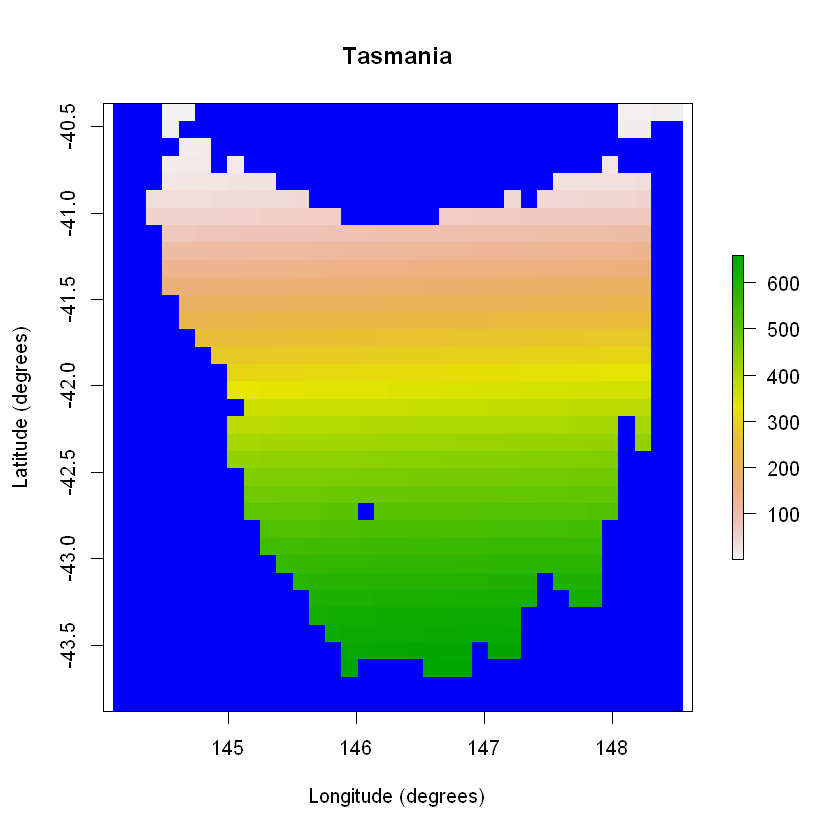

In [14]:
#build the raster of channel
coordinates <- data.frame(x = rep(seq(lonmin, lonmax, 0.127028885714286), gridlen),
                          y = rep(seq(latmin, latmax, 0.1005383142857144),each= gridlen))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = areaname,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

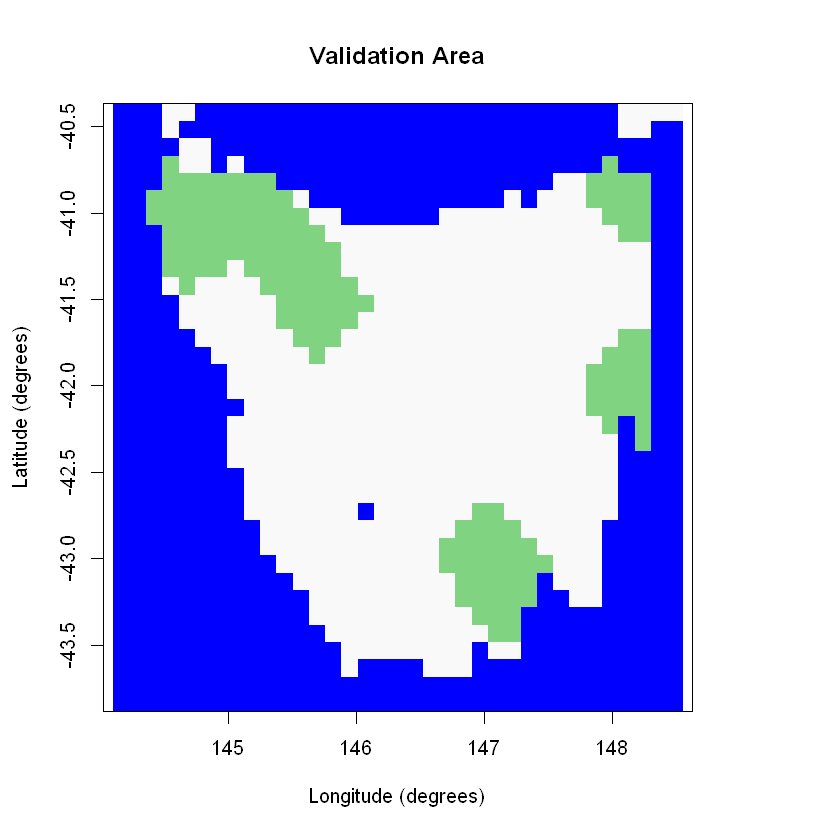

In [15]:
# Example validation area
example_vt_raster <- region$region_raster
example_vt_raster[landarea] <- 50
example_vt_raster[validation_target] <- 1000
example_vt_raster[-landarea]<- NA
raster::plot(example_vt_raster, main = "Validation Area",alpha=0.5,legend = FALSE,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

##### Environmental correlation
Next, we'll define a distance-based spatial correlation for applying environmental 
stochasticity within our model. The generated correlation data is compacted for 
computational efficiency (with large-scale models).

In [16]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, amplitude = 0.4, breadth = 500)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

##### Template model
Finally, we can build our template model with these and other fixed parameters.

[0. , 0.489, 1.4539, 1.947, 1.5079,0.547]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.976, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.899, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.84, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.0, 0.791, 0.0]

In [17]:
# Population (simulation) model template for fixed parameters
stage_matrix <- matrix(leslie_matrix, nrow = length(agegroup), ncol = length(agegroup), byrow = TRUE,
                       dimnames = list(agegroup,agegroup ))

### Step 2: Build generators for dynamically generating model parameters
Some model parameters are single values, whilst others are represented as arrays and
other multi-value data structures. Usually, we don't wish to sample each individual 
value within these multi-value parameters (in step 3), but to generate them dynamically
via one or more intermediate sampled parameters. Here we build generators for model 
initial abundance, carrying capacity, and dispersal.

##### Habitat suitability
Firstly, our initial abundance and carrying capacity generator utilizes an example
(mock) habitat suitability for our defined study region. 

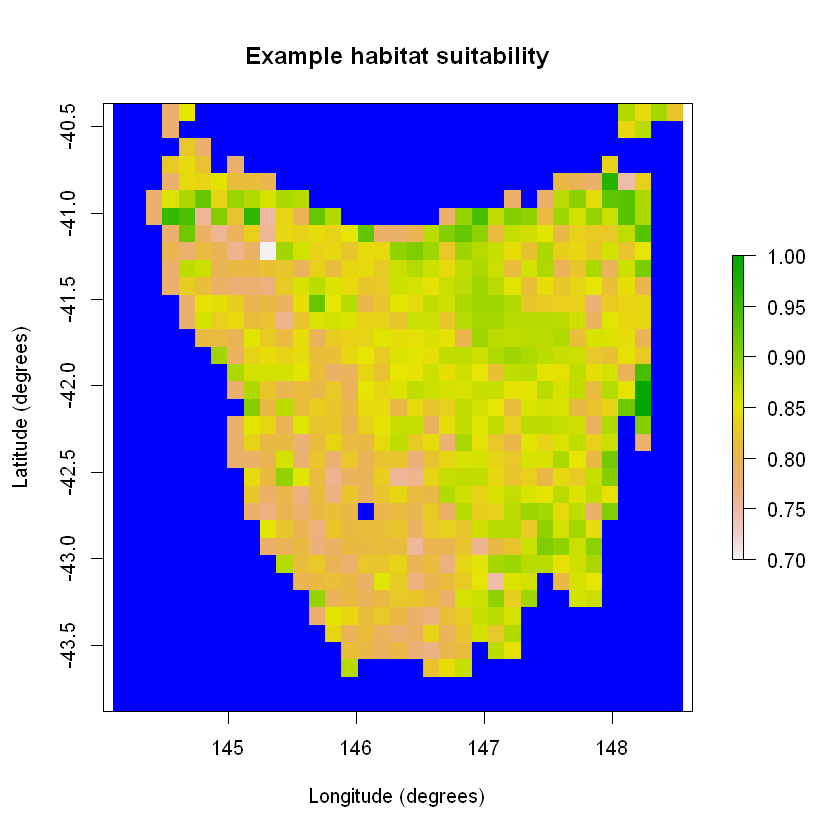

In [18]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

##### Initial abundance and carrying capacity generator
The generator utilizes generic template functionality for user-defined custom
functions. It uses sampled input parameters (initial total abundance and maximum cell
density), along with habitat suitability, to generate the desired output model 
parameters (initial abundance and carrying capacity) via these user-defined functions. 
Generators can also be configured to read values from files or generate values via 
probabilistic distributions. 

In [19]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              inputs = c("initial_n", "density_max"),
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
                                       stats::rmultinom(1, size = params$initial_n,
                                                      prob = params$example_hs)[,1]
                                   },
                                   call_params = c("initial_n", "example_hs"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$density_max*params$example_hs)
                                   },
                                   call_params = c("density_max", "example_hs"))
# capacity_gen$generate(input_values = list(initial_n = 15, density_max = 15)) # test

Tasman + Forestier is 43km * 33km. Dispersal is estimated via mark recapture data from billie. Devils which got recaptured one year apart are taken into the dataset to estimate the annual dispersal distance. 

https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/dispersal%20estimate%20tasman.ipynb

In [20]:
# Distance-based dispersal generator
dispersal_gen <- DispersalGenerator$new(region = region,
                                        dispersal_max_distance = 300, # in km 
                                        distance_scale = 1000,
                                        dispersal_friction = DispersalFriction$new(),
                                        inputs = c("dispersal_p", "dispersal_b"),
                                        decimals = 5)
dispersal_gen$calculate_distance_data() # pre-calculate
test_dispersal <- dispersal_gen$generate(input_values = list(dispersal_p = known_dispersal_p, 
                                                             dispersal_b = known_dispersal_b))
#head(test_dispersal$dispersal_data[[1]])

as(<dsCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(as(., "generalMatrix"), "TsparseMatrix") instead



##### Density Dependence

In [21]:
# Define neighborhoods based on a 12 km home range from each 
# grid cell for density dependence calculations (using a dispersal generator)
distance_data <- dispersal_gen$distance_data[[1]]
nh_data <- distance_data[which(distance_data$distance_class <= 12), 2:1]

neighborhoods <- as.list(1:length(landarea))
for (i in 1:nrow(nh_data)) {
  neighborhoods[[nh_data$source_pop[i]]] <- c(neighborhoods[[nh_data$source_pop[i]]],
                                               nh_data$target_pop[i])
}
#neighborhoods[1:3] # examine

In [22]:
# User-defined function for Ricker logistic density dependence via neighborhoods
density_dependence <- list(
  neighborhoods = neighborhoods,
  function (params) {
    
    # Apply logistic density dependence using neighborhoods
    growth_rate_max <- params$growth_rate_max
    nh_density_abundance <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$density_abundance[nh_indices])
                                          }))
    nh_carrying_capacity <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$carrying_capacity[nh_indices])
                                          }))
    occupied_indices <- params$occupied_indices
    growth_rate <- growth_rate_max*(1 - (nh_density_abundance[occupied_indices]/
                                           nh_carrying_capacity[occupied_indices]))
    params$transition_array[, , occupied_indices] <-
      params$apply_multipliers(params$transition_array[, , occupied_indices],
                               params$calculate_multipliers(growth_rate))
    
    
    # Remove fecundities for single thylacines
    single_indices <- which(nh_density_abundance == 1)
    params$transition_array[, , single_indices] <-
      (params$transition_array[, , single_indices]*as.vector(+(!params$fecundity_mask)))
    
    return(params$transition_array)
  }
)

In [23]:
#stage_matrix # examine
model_template <- PopulationModel$new(region = region,
                                      time_steps = simulation_years, # years
                                      years_per_step = simulation_intervals,
                                      populations = region$region_cells, 
                                      stages = length(agegroup),
                                      stage_matrix = stage_matrix,
                                      demographic_stochasticity = TRUE,
                                      standard_deviation = 0.05,
                                      correlation = correlation,
                                      density_dependence = density_dependence,
                                      results_selection = c("abundance"),)

### Step 3: Sample model and generator parameters for each simulation
In order to explore the model parameter space to find the best models, we generate
Latin hypercube samples of model and generator parameters to be simulated, using the
*LatinHypercubeSampler* class. This class has functionality for generating sample
parameters via Uniform, Normal, Lognormal, Beta, and Triangular distributions.

In [24]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()

#logistic growth model 0.74
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/logistic%20population%20growth%20tasman.ipynb
lhs_gen$set_uniform_parameter("growth_rate_max", lower = 0.4, upper = 0.6, decimals = 2)

#automatically fetched
lhs_gen$set_uniform_parameter("density_max", lower = as.integer(maxden*0.5), 
                              upper = as.integer(maxden*1.5), decimals = 2)
lhs_gen$set_uniform_parameter("initial_n", lower = as.integer(population_size[1]/2*0.9),
                              upper = as.integer(population_size[1]/2*1.1), decimals = 0)
lhs_gen$set_uniform_parameter("dispersal_p", lower = known_dispersal_p*0.9, 
                              upper = known_dispersal_p*1.1, decimals = 4)
lhs_gen$set_uniform_parameter("dispersal_b", lower = as.integer(known_dispersal_b*0.9),
                              upper = as.integer(known_dispersal_b*1.1), decimals = 2)
sample_data <- lhs_gen$generate_samples(number = num_of_sims)

#save as pickle
save(sample_data, file="sample data.Rda")

### Step 4: Build a simulation manager to run each simulation
We now wish to run a simulation for each set (or row) of sampled parameters. The
*SimulationManager* class manages the generation of parameters (via the generators),
the running the model simulations, and writing simulation results to disk. It also
maintains a log of each simulation's success and any errors or warnings encountered.

In [25]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, dispersal_gen),
                                     parallel_cores = 2,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run(results_dir = tempdir())
run_output$summary
#dir(OUTPUT_DIR, "*.RData") # includes result files 
#dir(OUTPUT_DIR, "*.txt") # plus simulation log

[1] "1000 of 1000 sample models ran and saved results successfully with warnings"

Note that the output directory contains a R-data result files for each sample simulation
and a simulation log file.

### Step 5: Build a results manager to generate summary results (metrics)
We now wish to collate summary results for each of our simulations via the 
*ResultsManager* class. This manager loads the results from each sample simulation into
an intermediate *PopulationResults* class object, which dynamically generates further 
results. We need to define functions for calculating summary metrics, as well as any 
matrices (one row of values per simulation) that we may be interested in examining. Each
metric (or matrix) is associated with a user-defined function that utilizes results object 
attributes, or alternatively direct access to an attribute may be defined via a string.
Once generated, the result metrics (a data frame) and/or matrices (a list) can be 
accessed via the manager. We may utilize the collated results in a variety of ways. 
However, with the objective of selecting the best models, we wish to compare (or 
validate) these result metrics to (with) known or desired target patterns (in step 6).

In [26]:
# #validation area id
# iden=identity$ID

# results_manager <- ResultsManager$new(simulation_manager = sim_manager,
#                                       simulation_results = PopulationResults$new(),
#                                       summary_metrics = c("p2","p3","p4"),
#                                       summary_matrices = c("n"),
#                                       iden=identity$ID,
#                                       summary_functions = list(
                                          
#                                           #results refer to actual output rdata file
#                                         p2 = function(results,iden) {
#                                           sum(results$abundance[iden,2])                                            
#                                         },                                          
#                                         p3 = function(results,iden) {
#                                           sum(results$abundance[iden,3])
#                                         },
#                                         p4 = function(results,iden) {
#                                           sum(results$abundance[iden,4])
#                                         },
#                                         n = "abundance"),
#                                       parallel_cores = 2)
# gen_output <- results_manager$generate()
# gen_output$summary
# #dir(OUTPUT_DIR, "*.txt") # plus generation log
# # results_manager$summary_metric_data
# # results_manager$summary_matrix_list

In [27]:
results_manager <- ResultsManager$new(simulation_manager = sim_manager,
                                      simulation_results = PopulationResults$new(),
                                      summary_metrics = c("p2","p3","p4","p5","p6","p7"),
                                      summary_matrices = c("n"),
                                      summary_functions = list(
                                        p2 = function(results) {
                                          results$all$abundance[2]
                                        },
                                        p3 = function(results) {
                                          results$all$abundance[3]
                                        },
                                        p4 = function(results) {
                                          results$all$abundance[4]
                                        },
                                        p5 = function(results) {
                                          results$all$abundance[5]
                                        },
                                        p6 = function(results) {
                                          results$all$abundance[6]
                                        },
                                        p7 = function(results) {
                                          results$all$abundance[7]
                                        },
                                        p8 = function(results) {
                                          results$all$abundance[8]
                                        },
                                        p9 = function(results) {
                                          results$all$abundance[9]
                                        },
                                        p10 = function(results) {
                                          results$all$abundance[10]
                                        },
                                        n = "all$abundance"),
                                      parallel_cores = 2)
gen_output <- results_manager$generate()
gen_output$summary
#dir(OUTPUT_DIR, "*.txt") # plus generation log
# results_manager$summary_metric_data
# results_manager$summary_matrix_list

[1] "1000 of 1000 summary metrics/matrices generated from sample results successfully"

In [28]:
#save as pickle
save(results_manager, file="models.Rda")

### Step 6: Build a validator to select a model ensemble
We now select and analyze our 'best' models via a *Validator* class object, which by
default utilizes an approximate Bayesian computation (ABC) approach (Beaumont, Zhang, 
& Balding, 2002) provided by the *abc* library (Csillery et al., 2015). The validator
can be configured appropriately for a problem domain (see the *abc* documentation). 
Here we use the default configuration to select the best 3 models, along with a weight
value, which is indicative of the congruence between each model's summary metrics and 
the corresponding target patterns. Also provided (with the default settings) is a 
diagnostic output (PDF) file, containing statistical information for analyzing the 
contribution of model parameters in the selection/validation process (see the *abc* 
documentation). For our simple demonstration the metrics and corresponding targets are 
relatively trivial, having the aim of producing stable population abundances with high 
harvest. However, the package facilitates the use more complex spatio-temporal metrics 
and targets (demonstrated in more advanced vignettes).

In [29]:
#load pickle files so no need to retrain
load("models.Rda")
load("sample data.Rda")

In [30]:
#showna
validation_var=results_manager$summary_metric_data
validation_var[!complete.cases(validation_var),]

,index,p2,p3,p4,p5,p6,p7,p8,p9,p10
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,20,NA,NA,NA,NA,NA,NA,NA,NA,NA
32,32,NA,NA,NA,NA,NA,NA,NA,NA,NA
37,37,NA,NA,NA,NA,NA,NA,NA,NA,NA
42,42,NA,NA,NA,NA,NA,NA,NA,NA,NA
45,45,NA,NA,NA,NA,NA,NA,NA,NA,NA
50,50,NA,NA,NA,NA,NA,NA,NA,NA,NA
51,51,NA,NA,NA,NA,NA,NA,NA,NA,NA
64,64,NA,NA,NA,NA,NA,NA,NA,NA,NA
69,69,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [31]:
#list of na
remove_index=which(!complete.cases(validation_var))

In [32]:
# Create a validator for selecting the 'best' example models
if (length(remove_index)==0)    {
    validator <- Validator$new(simulation_parameters = sample_data,
                           simulation_summary_metrics =
                             validation_var[-1],
                           observed_metric_targets = c(p2=as.integer(population_size[2]/2),
                                                       p3=as.integer(population_size[3]/2),
                                                       p4=as.integer(population_size[4]/2),
                                                       p5=as.integer(population_size[5]/2),
                                                       p6=as.integer(population_size[6]/2),
                                                       p7=as.integer(population_size[7]/2),
                                                       p8=as.integer(population_size[8]/2),
                                                       p9=as.integer(population_size[9]/2),
                                                       p10=as.integer(population_size[10]/2)),
                           output_dir = OUTPUT_DIR)

} else    {
    validator <- Validator$new(simulation_parameters = sample_data[-remove_index,],
                           simulation_summary_metrics =
                             validation_var[-remove_index,][-1],
                           observed_metric_targets = c(p2=as.integer(population_size[2]/2),
                                                       p3=as.integer(population_size[3]/2),
                                                       p4=as.integer(population_size[4]/2),
                                                       p5=as.integer(population_size[5]/2),
                                                       p6=as.integer(population_size[6]/2),
                                                       p7=as.integer(population_size[7]/2),
                                                       p8=as.integer(population_size[8]/2),
                                                       p9=as.integer(population_size[9]/2),
                                                       p10=as.integer(population_size[10]/2)),
                           output_dir = OUTPUT_DIR)
}

In [33]:
validator$run(tolerance = 0.25, output_diagnostics = TRUE)

12345678910
12345678910


Warning message:
"Validation function generated warning: All parameters are "none" transformed."


In [34]:
#rescale weights as they dont sum up to one
weights=validator$selected_simulations 
weights$weight=weights$weight/sum(weights$weight)

In [35]:
#get result
colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

growth_rate_max     density_max       initial_n     dispersal_p     dispersal_b 
   4.990030e-01    9.987089e+01    1.728242e+04    1.955137e-01    5.542156e+00

In [36]:
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)

[1] "validation_diagnostics.pdf"

In [37]:
forecast_manager <- ResultsManager$new(simulation_manager = sim_manager,
                                      simulation_results = PopulationResults$new(),
                                      summary_metrics = c("p22","p23","p24","p25","p26","p27","p28","p29","p30"),
                                      summary_matrices = c("n"),
                                      summary_functions = list(
                                        p22 = function(results) {
                                          results$all$abundance[22]
                                        },
                                        p23 = function(results) {
                                          results$all$abundance[23]
                                        },
                                        p24 = function(results) {
                                          results$all$abundance[24]
                                        },
                                        p25 = function(results) {
                                          results$all$abundance[25]
                                        },
                                        p26 = function(results) {
                                          results$all$abundance[26]
                                        },
                                        p27 = function(results) {
                                          results$all$abundance[27]
                                        },
                                        p28 = function(results) {
                                          results$all$abundance[28]
                                        },
                                        p29 = function(results) {
                                          results$all$abundance[29]
                                        },
                                        p30 = function(results) {
                                          results$all$abundance[30]
                                        },
                                        n = "all$abundance"),
                                      parallel_cores = 2)
projection <- forecast_manager$generate()

In [38]:
#showna
validation_var=forecast_manager$summary_metric_data
validation_var[weights$index,]

,index,p22,p23,p24,p25,p26,p27,p28,p29,p30
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,40869,40493,40719,40651,40710,40674,40688,40512,40042
4,4,38023,37998,38035,38105,37901,38362,38151,38195,38139
8,8,39311,39590,39426,39459,39355,39057,39432,39744,39663
9,9,35838,36020,35982,36173,36087,35769,36008,35923,35863
10,10,37213,37328,37367,37286,37380,37336,37623,37431,37523
27,27,44567,44573,44839,44387,44287,44597,44893,44443,44831
35,35,45981,46219,46297,46263,45580,45545,45846,46061,46033
43,43,65749,65635,66266,66953,66828,66660,67129,66858,66581
50,50,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [39]:
sample_data[weights$index,]

,growth_rate_max,density_max,initial_n,dispersal_p,dispersal_b
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.42,73.01,16397,0.2070,5.30
4,0.48,68.97,17927,0.1962,5.99
8,0.41,71.07,15575,0.1931,5.64
9,0.60,64.41,17650,0.2008,5.98
10,0.50,66.37,15992,0.1936,5.28
27,0.45,80.48,15527,0.1968,5.28
35,0.54,82.74,17094,0.1844,5.76
43,0.47,117.89,18005,0.1908,5.04
50,0.56,90.67,15764,0.1885,5.72
